## Kết nối đến thư mục Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/EdgeAIK03/M10K03_EdgeAI_Dataset_2'
os.chdir(project_path)

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/EdgeAIK03/M10K03_EdgeAI_Dataset_2


## Illegal Logging Detection (Phát hiện tiếng máy cưa)

### Load file dữ liệu từng mẫu và lấy thông tin:
Thông tin dữ liệu:
+ Số mẫu: 3163
+ Thời gian: 1s
+ Tần số lấy mẫu: 16000Hz
+ Định dạng file: WAV

Thông tin:
+ Vector 1D mô tả âm thanh
+ Phân loại: Z_Background, Chainsaw

In [3]:
import glob
import os
import json
import librosa

dataset_path = 'IllegalLoggingDetection'
data_path_lst = []
label_lst = []

fs = 16000

for data_path in glob.glob(f'{dataset_path}/*/*.wav'):
  label = os.path.basename(data_path).split('.')[0]
  data_path_lst.append(data_path)
  label_lst.append(label)

print(f'Số lượng dữ liệu: {len(data_path_lst)}')
print(f'Phân loại: {set(label_lst)}')

sample_dict = {}
for lb in set(label_lst):
  idx = label_lst.index(lb)
  wav_file, sr = librosa.load(data_path_lst[idx], sr=fs)
  print(f'Số lượng ({lb}): {label_lst.count(lb)} (time= {len(wav_file)/sr}s) (fs= {sr})')
  sample_dict[lb] = wav_file

Số lượng dữ liệu: 3163
Phân loại: {'Chainsaw', 'Z_Background'}
Số lượng (Chainsaw): 127 (time= 1.0s) (fs= 16000)
Số lượng (Z_Background): 3036 (time= 1.0s) (fs= 16000)


### Vẽ tín hiệu Audio

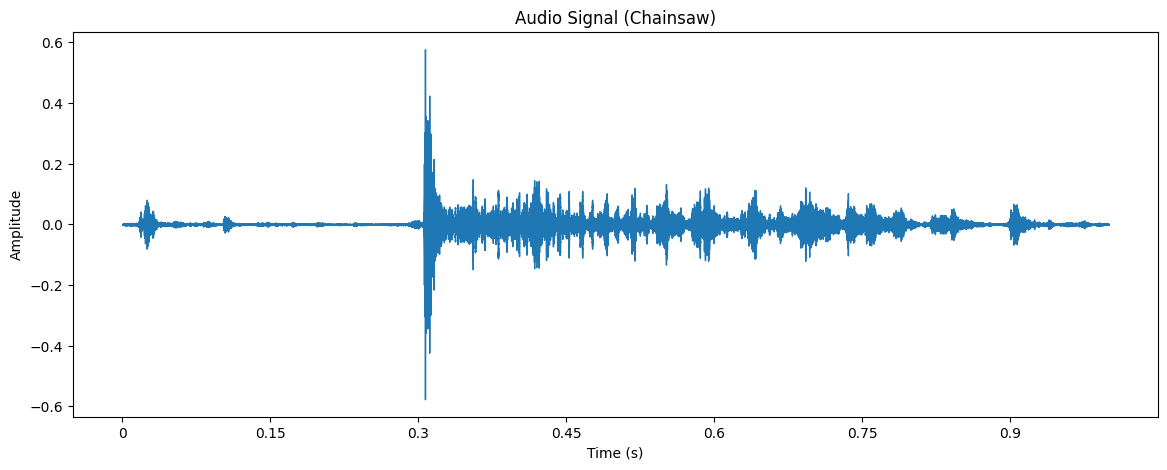

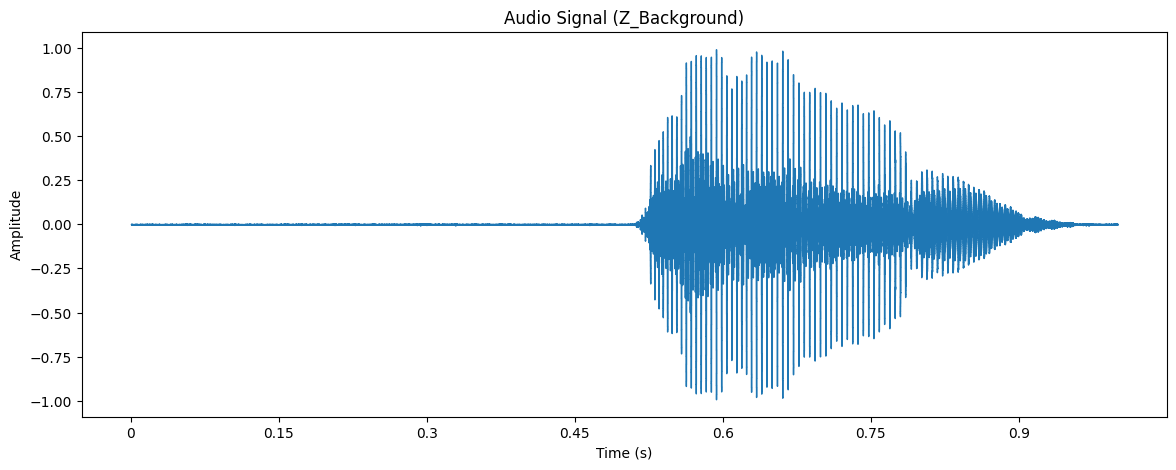

In [4]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display

fs = 16000

for lb, wav_file in sample_dict.items():
  plt.figure(figsize=(14, 5))
  librosa.display.waveshow(wav_file, sr=fs)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title(f"Audio Signal ({lb})")
  plt.show()

  ipd.display(ipd.Audio(wav_file, rate=fs))

### Xây dựng hàm trích đặc trưng MFE (Mel-filterbank energy features)

In [5]:
import librosa
import numpy as np


def mfe(wav_file, fs, frame_length, frame_stride, n_mels):
  """
  Tạo đặc trưng MFE (Mel-filterbank energy features)

  Args:
      data (1D array-like): Dữ liệu audio đầu vào.
      fs (int): Tần số mẫu (Hz).
      frame_length (float): Chiều dài khung (s).
      frame_stride (float): Khoảng trượt (s).
      n_mels (int): Số băng tần Mel (s)
  Returns:
      np.array: Mảng 2D.
  """

  n_fft = int(frame_length * fs)
  hop_length = int(frame_stride * fs)

  mel_spectrogram = librosa.feature.melspectrogram(y=wav_file, sr=fs, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

  # Tính năng lượng Mel-Frequency (bằng cách lấy log)
  mel_energy = librosa.power_to_db(mel_spectrogram, ref=np.max)

  # Chuẩn hóa
  normalized_mel = (mel_energy - np.min(mel_energy)) / (np.max(mel_energy) - np.min(mel_energy))

  return normalized_mel, hop_length

### Áp dụng MFE vào các mẫu audio phân loại khác nhau

(40, 42)


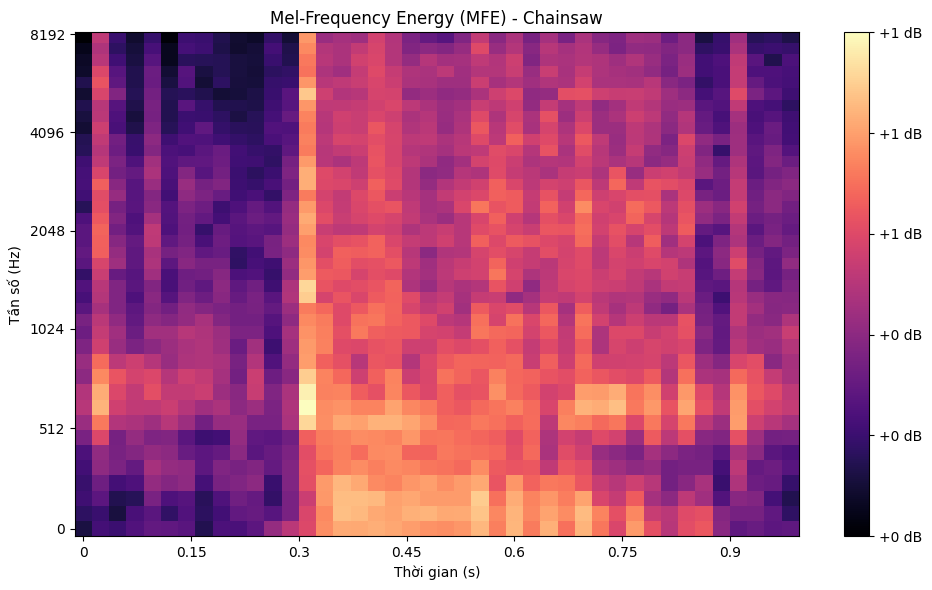

(40, 42)


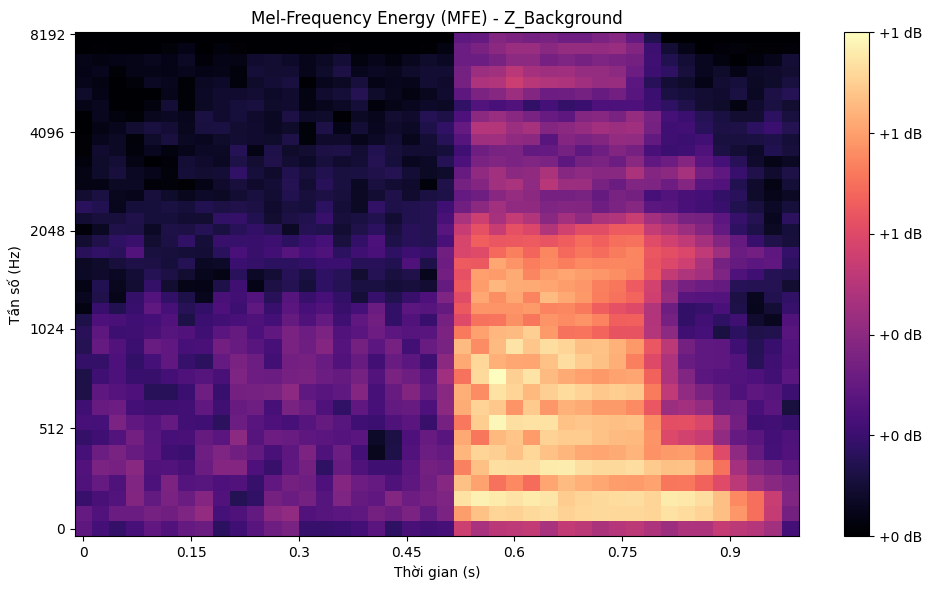

In [6]:
frame_length = 0.032
frame_stride = 0.024
n_mels = 40

for lb, wav_file in sample_dict.items():
  mel_feature, hop_length = mfe(wav_file, fs, frame_length, frame_stride, n_mels=n_mels)
  print(mel_feature.shape)
  plt.figure(figsize=(10, 6))
  librosa.display.specshow(mel_feature, sr=fs, hop_length=hop_length, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'Mel-Frequency Energy (MFE) - {lb}')
  plt.xlabel('Thời gian (s)')
  plt.ylabel('Tần số (Hz)')
  plt.tight_layout()
  plt.show()

### Trích xuất đặc trưng toàn bộ file audio.
Thông tin đặc trưng:
+ Số mẫu: 3163
+ Size: 40x42 sang 1x1680
+ Định dạng file: NPY

In [7]:
fs = 16000
frame_length = 0.032
frame_stride = 0.024
n_mels = 40

output_path = r'IllegalLoggingDetection/features'

if os.path.exists(output_path):
  import shutil
  shutil.rmtree(output_path)

for idx, data_path in enumerate(data_path_lst):
  label = label_lst[idx]
  wav_file, sr = librosa.load(data_path, sr=fs)
  mel_feature, hop_length = mfe(wav_file, sr, frame_length, frame_stride, n_mels)
  mel_feature_flatten = mel_feature.flatten()
  npy_path = os.path.join(output_path, f'{label}.{idx:05d}.npy')
  os.makedirs(os.path.dirname(npy_path), exist_ok=True)
  np.save(npy_path, mel_feature_flatten)

<ipython-input-5-f8ff199c7eba>:28: RuntimeWarning: invalid value encountered in divide
  normalized_mel = (mel_energy - np.min(mel_energy)) / (np.max(mel_energy) - np.min(mel_energy))


## Responding to your voice (Phản hồi giọng nói bằng từ khoá)

### Load file dữ liệu từng mẫu và lấy thông tin:
Thông tin dữ liệu:
+ Số mẫu: 2062
+ Thời gian: 1s
+ Tần số lấy mẫu: 16000Hz
+ Định dạng file: WAV

Thông tin:
+ Vector 1D mô tả âm thanh
+ Phân loại: HelloWorld, Unknown, Noise

In [8]:
import glob
import os
import json
import librosa

dataset_path = 'Responding2YourVoice'
data_path_lst = []
label_lst = []

fs = 16000

for data_path in glob.glob(f'{dataset_path}/*/*.wav'):
  label = os.path.basename(data_path).split('.')[0]
  data_path_lst.append(data_path)
  label_lst.append(label)


print(f'Số lượng dữ liệu: {len(data_path_lst)}')
print(f'Phân loại: {set(label_lst)}')

sample_dict = {}
for lb in set(label_lst):
  idx = label_lst.index(lb)
  wav_file, sr = librosa.load(data_path_lst[idx], sr=fs)
  print(f'Số lượng ({lb}): {label_lst.count(lb)} (time= {len(wav_file)/sr}s) (fs= {sr})')
  sample_dict[lb] = wav_file


Số lượng dữ liệu: 2062
Phân loại: {'noise', 'helloworld', 'unknown'}
Số lượng (noise): 720 (time= 1.0s) (fs= 16000)
Số lượng (helloworld): 621 (time= 1.0s) (fs= 16000)
Số lượng (unknown): 721 (time= 1.0s) (fs= 16000)


### Vẽ tín hiệu Audio

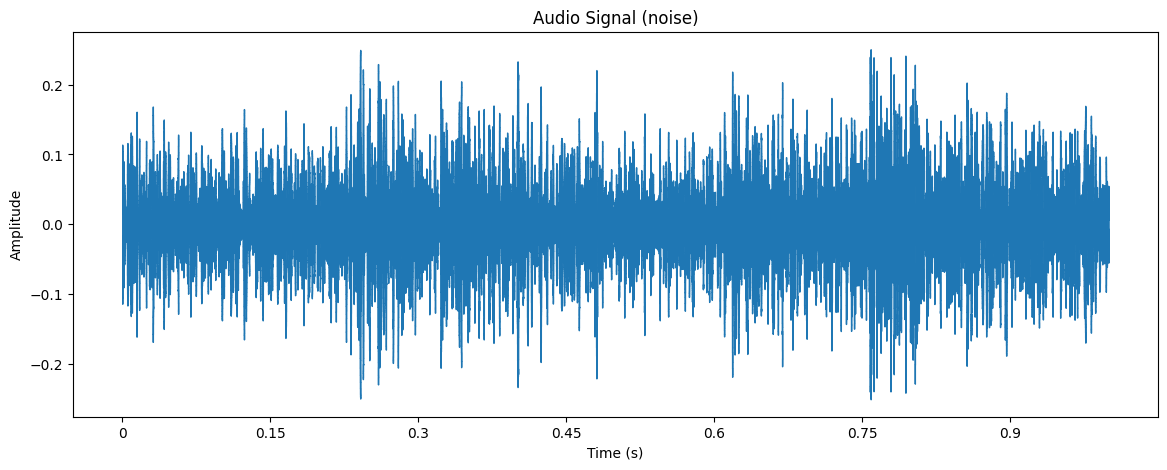

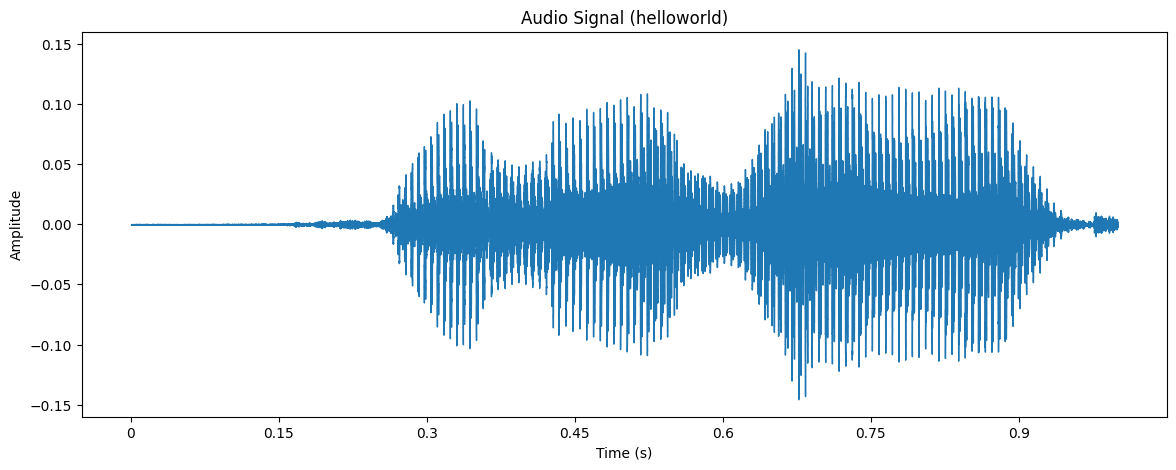

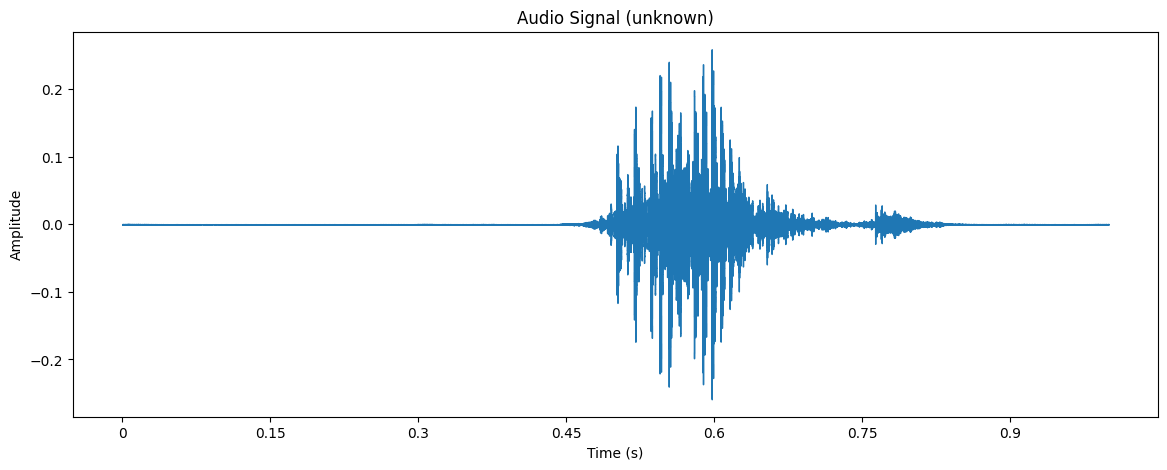

In [9]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display

fs = 16000

for lb, wav_file in sample_dict.items():
  plt.figure(figsize=(14, 5))
  librosa.display.waveshow(wav_file, sr=fs)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title(f"Audio Signal ({lb})")
  plt.show()

  ipd.display(ipd.Audio(wav_file, rate=fs))

### Xây dựng hàm trích đặc trưng MFCC (Mel-Frequency Cepstral Coefficients)

In [10]:
import librosa
import numpy as np


def mfcc(wav_file, fs, frame_length, frame_stride, n_mfcc, fmin, fmax):
  """
  Tạo đặc trưng MFCC (Mel-Frequency Cepstral Coefficients)

  Args:
      data (1D array-like): Dữ liệu audio đầu vào.
      fs (int): Tần số mẫu (Hz).
      frame_length (float): Chiều dài khung (s).
      frame_stride (float): Khoảng trượt (s).
      n_mfcc (int): Số coefficients MFCC
  Returns:
      np.array: Mảng 2D.
  """

  n_fft = int(frame_length * fs)  # Số mẫu FFT (320 mẫu)
  hop_length = int(frame_stride * fs)  # Số mẫu trượt (160 mẫu)

  # Tính MFCC
  mfccs = librosa.feature.mfcc(y=wav_file, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, fmin=fmin, fmax=fmax)

  # Chuẩn hóa MFCC (giống Edge Impulse)
  normalized_mfccs = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs))

  return normalized_mfccs, hop_length

### Áp dụng MFE vào các mẫu audio phân loại khác nhau

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


(40, 42)


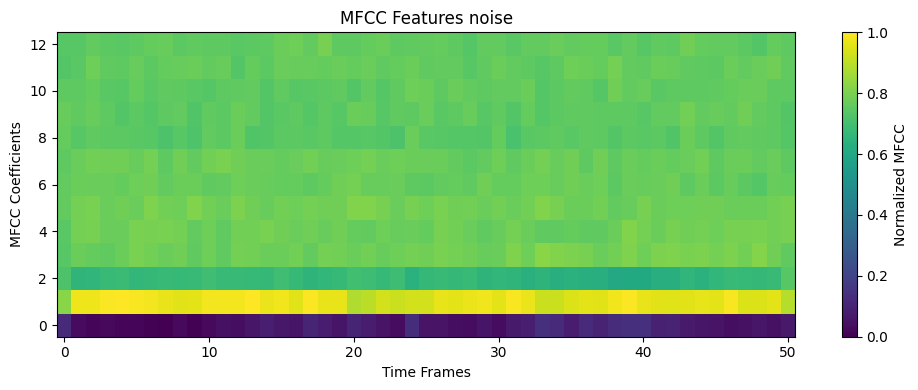

(40, 42)


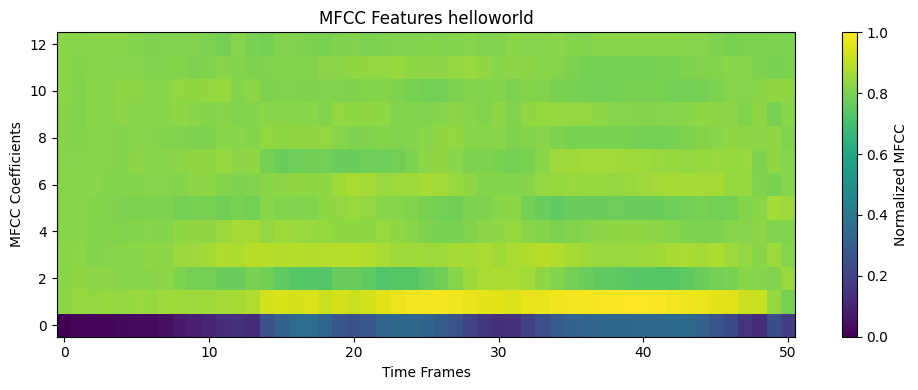

(40, 42)


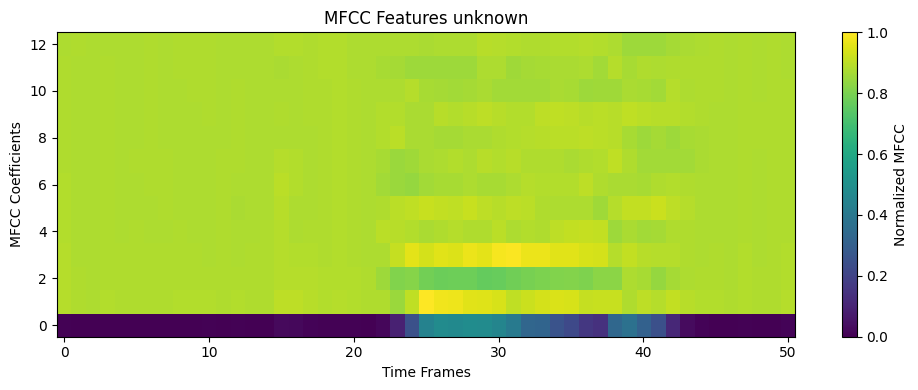

In [11]:
fs = 16000
frame_length = 0.02
frame_stride = 0.02
n_mfcc = 13
fmin = 300
fmax = None


for lb, wav_file in sample_dict.items():
  mfcc_feature, hop_length = mfcc(wav_file, fs, frame_length, frame_stride, n_mfcc, fmin, fmax)
  print(mfcc_feature.shape)
  plt.figure(figsize=(10, 4))
  plt.imshow(mfcc_feature, aspect='auto', origin='lower', cmap='viridis')
  plt.colorbar(label='Normalized MFCC')
  plt.title(f'MFCC Features {lb}')
  plt.xlabel('Time Frames')
  plt.ylabel('MFCC Coefficients')
  plt.tight_layout()
  plt.show()

### Trích xuất đặc trưng toàn bộ file audio.

### Trích xuất đặc trưng toàn bộ file audio.
Thông tin đặc trưng:
+ Số mẫu: 2062
+ Size: 13x51
+ Định dạng file: NPY

In [12]:
fs = 16000
frame_length = 0.02
frame_stride = 0.02
n_mfcc = 13
fmin = 300
fmax = None

output_path = r'Responding2YourVoice/features'

if os.path.exists(output_path):
  import shutil
  shutil.rmtree(output_path)

for idx, data_path in enumerate(data_path_lst):
  label = label_lst[idx]
  wav_file, sr = librosa.load(data_path, sr=fs)
  mfcc_feature, hop_length = mfcc(wav_file, fs, frame_length, frame_stride, n_mfcc, fmin, fmax)
  npy_path = os.path.join(output_path, f'{label}.{idx:05d}.npy')
  os.makedirs(os.path.dirname(npy_path), exist_ok=True)
  np.save(npy_path, mfcc_feature)